# 卷积神经网络 Convolutional Neural Networks
---
在本节我们一个CNN来分类 CIFAR-10 的数据图像，数据库的images是 small color images, 总共分为10类。一些示例图像如下图所示

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### cuda测试

CUDA (http://pytorch.org/docs/stable/cuda.html)
这些是更大的图像(32x32x3)，通过使用GPU来加快培训时间可能会很有用。 CUDA是一个并行计算平台，CUDA张量与典型张量相同，只是它们利用GPU进行计算

In [2]:
import torch 
import numpy as np

# 检测gpu是否可用 
train_on_gpu = torch.cuda.is_available()  #  True or False
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not train_on_gpu: 
    print('CUDA is not available.  Training on CPU ...')
else: 
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## (一) 加载数据 （分割数据集）
> Docs > [torchvision.datasets](http://pytorch.org/docs/stable/torchvision/datasets.html)

+ 定义 transforms
+ 加载训练和测试数据 -- 将训练数据分为训练和验证集 
+ 然后为这些数据集的每一个创建 DataLoader --> 创建3个Data

In [8]:
import torch 
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
# from torchvision import transforms 
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
valid_size = 0.2   

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

##################################
# 从 train_data 中分割valid_data #
#################################
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = np.int(np.floor(num_train * valid_size))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified


## (一) 加载数据 -- 带数据增强
> 本文是针对深度学习(专门针对图像)的数据增强技术的全面综述: https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced

> 学习pytorch中的transformas https://pytorch.org/docs/stable/torchvision/transforms.html

下面我们做一些简单的数据增强(data augmentation): by randomly flipping and rotating the given image data. 我们通过定义torchvision `transform` 来实现这一点，在上面的链接了解用于预处理和增强数据的所有transform

这种类型的数据(上面的10类)扩充应在这些图像上增加一些位置多样性，以便我们在此数据上训练模型时，在面对几何变化时它将很健壮(即无论面向哪个方向，它都将识别出船只)。 建议您选择一个或两个变换。

In [3]:
import numpy as np
import torch 

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2
batch_size = 20

# 定义 transforms
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), 
                                 transforms.RandomRotation(15), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 读取数据
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# 分割数据
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = np.int(np.floor(num_train * valid_size))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified


## 使用新的定义网络结构的语法(有问题)

另一种定义网络结构的方法：
```python
def __init__(self):
    super(Modelname, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 16, 2, stride=2), 
        nn.MaxPool2d(2, 2), 
        nn.ReLU(True), 
        
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.MaxPool2d(2, 2)
        nn.ReLU(True)
    )
```

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Moudle):
    def __init__(self, x):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.ReLU(True)
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(True)
            nn.MaxPool2d(2, 2),
            
            
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(True)
            nn.MaxPool2d(2, 2),
            
            
            #################################
            # 出问题了，这里要对卷积层的输出 #
            # 做 flatten 不知道这样写怎么做 #
            ###############################
            
          
        
        )

解答：这种方法是比较常见的定义网络的方法，其思想是按照block来定义，且可以给各个部分明明。比如我们前面见过的分成两块`self.features`和`self.clasifier`的;另外举一个例子：

In [ ]:
'''example, 不要运行'''

class CNN(nn.Module) :

    def __init__(self) :
        super().__init__()
        # Your code here
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        ## flattern
        fc1_size = (img_size[0] // 2 // 2) * (img_size[1] // 2 // 2) * 32
        self.fc1 = nn.Sequential(
            nn.Linear(fc1_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, len(classes)),
            nn.LogSoftmax(dim = 1)
        )
    
    def forward(self, x) :
        # Your code here
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

---

In [4]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'] 

### 对于一个新的数据集可视化一batch的训练数据
+ 上面载入数据的时候对数据做了 **normalization**
+ 需要做 **un-normalize** 才能display出来图片

[引述前面的内容]什么是图像normalize？例如对于任意颜色通道，normalize就是：

$$
\rm input[channel] = \frac{(input[channel] - mean[channel])}{std[channel]}
$$   

+ 图像值(input[channel])减去平均值：**中心化**(centers the data around 0)
+ 再除以图像的标准差std将值压缩到-1到1之间：归一化
+ **标准化/归一化/normalize有助于使网络工作权重保持接近零，从而使反向传播更加稳定。 如果没有规范化，网络将往往无法学习**   

In [4]:
# Visualize a Batch of Training Data
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # 看上面的公式
    plt.imshow(np.transpose(img, (1, 2, 0))) # permute the axes according to the values given. convert from Tensor image

tensor([5, 2, 5, 7, 2, 8, 3, 4, 4, 9])


C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


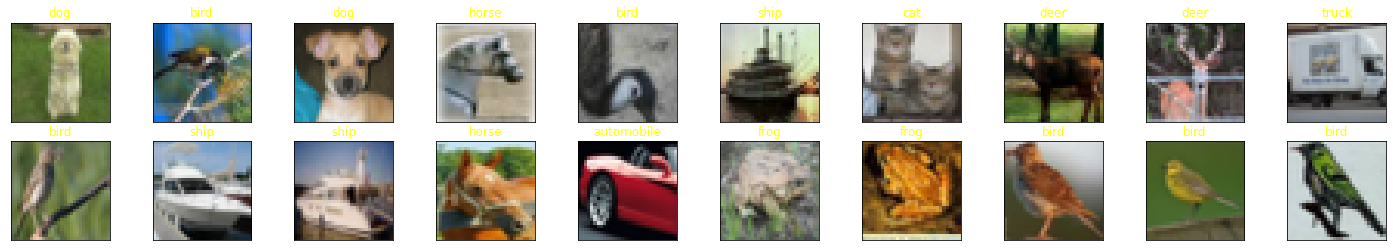

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(labels[:10]) #tensor([2, 8, 4, 1, 3, 3, 3, 2, 9, 4])

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # print(labels[idx]) tensor(2) tensor(8)..
    # labels 是读取的所有的images的标签，labels[idx] 输出的是类别编号，真正的name还要从 class中去索引
    ax.set_title(classes[labels[idx]], color='yellow')                                                      

In [6]:
print(classes[labels[0]])
print(classes[labels[1]])
print(classes[labels[2]])
print(classes[labels[3]])


dog
bird
dog
horse


再仔细的看一幅图

在这里，我们将归一化的红、绿、蓝(RGB)颜色通道(normalized red, green, and blue (RGB) color channels)看作三个独立的灰度图像( grayscale intensity images)。

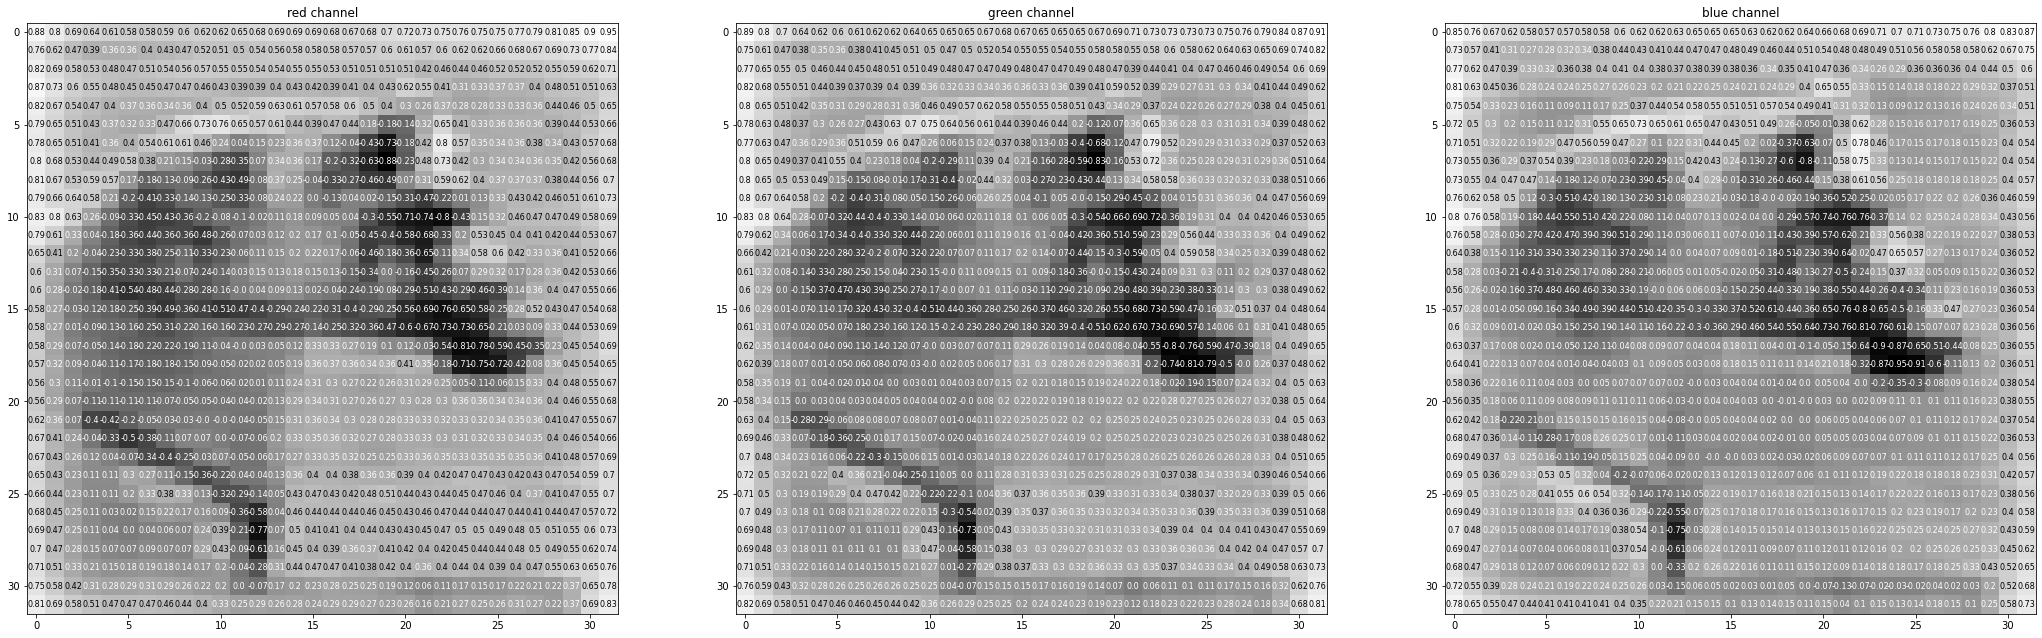

In [7]:
# 单独提取第4幅image
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):  # rgb_img.shape[0]= 3 通道
    ax = fig.add_subplot(1, 3, idx + 1)  # 1行3列
    img = rgb_img[idx]                   # img 是个通道的数组   
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])          # 0 代表 red
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [8]:
print(rgb_img.shape)

(3, 32, 32)


---
## (二) 定义卷积网络的architecture 

> Architecture](http://pytorch.org/docs/stable/nn.html)   

> `nn.Linear`: Applies a linear transformation to the incoming data: $xA^T+b$     
`nn.Conv1d`: Applies a 1D convolution over an input signal composed of several input planes.

现在我们来定义CNN的网络结构，和MLP使用线性连接 `nn.Linear()` 全连接层不同，构建卷积网络需要使用：
+ Convolutional layers 卷积层
+ Maxpooling layers 池化层
+ The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

## Pytorch 语法1 卷积层 池化层
+ [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), 这可以被认为是一堆 过滤后的图像/stack of filtered images
+ [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d)，减少输入的x-y大小(reduce the x-y size of an input)，只保留前一层中最active的像素(the most _active_ pixels)
  + 采用一个2*2的filter，max pooling是在每一个区域中寻找最大值
  + 注意：这里的pooling操作是特征图缩小(down-sample)，有可能影响网络的准确度，因此可以通过增加特征图的深度来弥补（这里的深度变为原来的2倍）。
  + 在卷积神经网络中，而池化层往往在卷积层后面，通过池化来降低卷积层输出的特征向量，同时改善结果（不易出现过拟合）。
  + 池化作用于图像中不重合的区域, 一般池化由于每一池化窗口都是不重复的，所以size<=stride
  + 池化的filter没有需要学习的参数：静态属性

```python
CLASStorch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')
```
> [PyTorch 中，nn 与 nn.functional 有什么区别？](https://www.cnblogs.com/pythonClub/p/10417754.html)      


+ bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

```python 
CLASStorch.nn.MaxPool2d(kernel_size: Union[T, Tuple[T, ...]], stride: Optional[Union[T, Tuple[T, ...]]] = None, padding: Union[T, Tuple[T, ...]] = 0, dilation: Union[T, Tuple[T, ...]] = 1, return_indices: bool = False, ceil_mode: bool = False)
```


下图是一个两个卷积层的网络，代码已经给出了一个卷积层和一个最大值池化层，任务是补充完成这个网络


<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />   

+ TODO：定义具有多个卷积层的模型，并定义前馈网络行为。

要知道再网络中包含越多的卷积层，模型就能检测到约复杂的 color and shape patterns. 建议最终模型包括2或3个卷积层 + 线性层 + dropout正则化以避免过度拟合。   
作为定义自己的模型的起点，查看相关模型的现有研究和实现是一个很好的实践。例如查看 [此PyTorch分类示例/classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) 或 [此更复杂的Keras示例](https://github.com/keras-team/keras-docs-zh/blob/master/sources/examples/cifar10_cnn.md) 很有用，以帮助确定最终结构。

### 卷积层的输出体积Output volume for a convolutional layer   

为了**计算给定卷积层的输出大小**，我们可以执行以下计算（摘自斯坦福大学的cs231n课程）：
> We can compute the spatial size of the output volume as a function of the **input volume size (W)**, **the kernel/filter size (F)**, **the stride with** which they are applied (S), and the amount of zero **padding** used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.
+ (7-3+2x0)/1 + 1 = 5
+ (7-3+2x0)/2 + 1 = 3

确定padding的方法：例如7x7的卷积核放在右侧边缘将有3个需要填充则padding是3. --> 使得输出和输入同样的size

卷积层参数问题：`K*F*F*D_in + K`: `K个filter*filter宽*filter长*上一层的输出深度 + K个偏置`

> 跟上一层的输出有什么关系：上一层3channels, 需要的filter fxfx3, 例如16个输出为 wxwx16, 则接着的filter为 fxfx16

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# 定义卷积网络结构
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 最大池化层
        self.pool = nn.MaxPool2d(2, 2) # 池化的stride和size一般一样大：2 downsize by 2
        # 卷积层1
        # 卷积层输入的的size是(32,32,3) --> (32-3+2x1)/1 + 1 =32 --> 输出的size (32,32,16) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, stride=1)  # 输入3通道RGB，输出16通道，卷积核3x3(x3)-> 16个卷积filter输出16深度卷积层
        # (32,32,16) * Maxpool --> (16,16,16) --> (16-3 + 2x1)/1+1= 16 --> (16,16,32)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 输入16通道，使用32个卷积核，卷积核3x3(3) -> 32
        # (16,16,32) * Maxpool --> (8,8,32) --> (8,8,64)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 输出图像的size要使用公式计算
        # (8,8,64) * Maxpool --> (4,4,64)

        # 最后一层的size是 (4,4,64)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # 添加卷积和最大池化层的序列
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)  # x.shape[0] 就是batchsize，-1表示全部拉平 64*4*4
        # x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x))
        return x
model = Net()
print(model)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


【说明】
+ `self.conv1(x)`: 3D array (padding=1) 和 3x3 的核卷积，输出<`_`>x<`_`>x16的卷积层结果
+ 在上面的代码中，错误的把最大池化的stride S 当成卷积时候的stride
+ **dropout 是定义给全连接层用的**

---
## (三) 训练卷积神经网络
+ 设定损失函数核权重更新方法
+ 设置epochs, 循环epochs
 + 决定loss可视化的策略：
   + 每个epoch输出一个 train_loss, 输出一个 valid_loss，
   + 然后每个epoch都比较 valid_loss是否是最小valid_loss，若是保存当前模型为最优模型
+ 训练过程(遍历epoch，在每个epoch)：
 + **打开训练模式**
 + 从a batch of data中进行训练/学习的步骤：
 + 清除梯度信息
 + 前向计算输出
 + 比较输出和label计算loss
 + 反向计算梯度
 + 更新权重
 + 更新训练损失

### 定义损失函数和优化器 criterion/optimizer
确定最适合此分类任务的损失和优化函数，上面的链接代码示例可能是一个很好的参考。
> 例如查看 [此PyTorch分类示例/classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) 或 [此更复杂的Keras示例](https://github.com/keras-team/keras-docs-zh/blob/master/sources/examples/cifar10_cnn.md)    

密切关注学习速率的值，因为这个值决定了你的模型如何收敛到一个小误差。

In [11]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
# cuda 检测
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 30
train_losses, valid_losses =[], []
valid_loss_min = np.inf

for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()  # 设置dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    model.eval() # 关闭fropout
    with torch.no_grad():  # 关闭autograd
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            valid_loss += loss.item() * images.size(0)
            
    # 一个epoch的loss 
    train_loss = train_loss/len(train_loader.sampler)   # --> 40000
    valid_loss = valid_loss/len(valid_loader.sampler)
    # 也会使用 
    # len(train_loader.dataset) --> 50000
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch {}/{}..'.format(e+1, epochs), 
          'Train loss:{:.4f}..'.format(train_loss), 
          'Valid loss:{:.4f}..'.format(valid_loss))
    
    #############################################    
    #save model if validation loss has decreased#
    # 注意一开始设为无限大。 注意dict后面的()   ####
    #############################################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased: ({:.6f} --> {:.6f})'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30.. Train loss:2.0282.. Valid loss:1.7315..
Validation loss decreased: (inf --> 1.731503)
Epoch 2/30.. Train loss:1.5849.. Valid loss:1.4568..
Validation loss decreased: (1.731503 --> 1.456754)
Epoch 3/30.. Train loss:1.3940.. Valid loss:1.3033..
Validation loss decreased: (1.456754 --> 1.303326)
Epoch 4/30.. Train loss:1.2578.. Valid loss:1.1738..
Validation loss decreased: (1.303326 --> 1.173771)
Epoch 5/30.. Train loss:1.1427.. Valid loss:1.0831..
Validation loss decreased: (1.173771 --> 1.083050)
Epoch 6/30.. Train loss:1.0459.. Valid loss:1.0248..
Validation loss decreased: (1.083050 --> 1.024818)
Epoch 7/30.. Train loss:0.9636.. Valid loss:0.9666..
Validation loss decreased: (1.024818 --> 0.966616)
Epoch 8/30.. Train loss:0.8927.. Valid loss:0.9350..
Validation loss decreased: (0.966616 --> 0.935023)
Epoch 9/30.. Train loss:0.8309.. Valid loss:0.9097..
Validation loss decreased: (0.935023 --> 0.909711)
Epoch 10/30.. Train loss:0.7754.. Valid loss:0.8438..
Validation loss

报错：
+ 2 module 'torch.nn' has no attribute 'device'
+ 16 module 'torch.nn' has no attribute 'zero_grad'
+ 16 module 'torch.optim' has no attribute 'zero_grad'

+ 26 TypeError: 'DataLoader' object is not callable

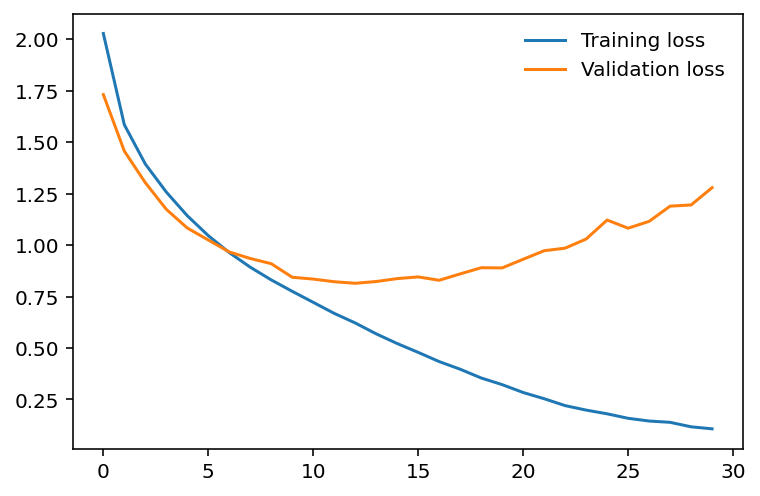

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

###  Load the Model with the Lowest Validation Loss

---
## (四) 测试训练保存的网络 

在没见过的数据上测试训练过的模型！ CNN的“好”结果将是在这些测试图像上获得约70％（或更多，请尽力做到最好！）的准确性。
+ 读取保存的模型(状态字典)
+ 打开eval模式，关闭autograd，遍历测试数据集
  + 遍历完之后 输出测试损失和精度值

> 一个读取模型的使用报错
```python
'function' object has no attribute 'copy''function' object has no attribute 'copy'
```
> 是因在保存模型的时候写错了
```python
# 错误
torch.save(model.state_dict, 'model.pt')
# 正确
torch.save(model.state_dict(), 'model.pt')
```


In [9]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

+ 加载这些模型字典之前需要（加载定义过的模型），因此如果对于别人训练的网络，我们要具有首先复原网络的能力 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_loss = 0.0
accuracy = 0.0
class_correct = [0 for i in range(10)]
class_total = list(0. for i in range(10))

model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    test_loss += loss.item() * images.size(0)
    
    # 精度
    ps = torch.exp(log_ps)
    top_p, top_k = ps.topk(1, dim=1)
    equals = top_k == labels.view(*top_k.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    #########################
    # 分别输出10类各类的精度 #
    ########################
    correct = np.squeeze(equals)
    for i in range(len(labels)):
        # 提取第i个label
        label = labels.data[i]
        class_correct[label] += correct[i].item()  # i对应的label + 1或0 正确+1，错误+10
        class_total[label] += 1 # 例如 label=5 的数据总数， 上面是所有数据 label 预测正确的数目

#输出测试损失和精度
test_loss = test_loss/len(test_loader.sampler)
accuracy = accuracy/len(test_loader)
print('Test loss:{:.4f}..'.format(test_loss), 
      'Accuracy:{:.4f}..'.format(accuracy))

###
for i in range(10):
    if class_total[i]>=0:   # 是指如果这个类有存在？
        print('Test Accuracy of {}: {}% ({}/{})'.format(classes[i], 100 * class_correct[i] / class_total[i], 
                                                        class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss:0.8225.. Accuracy:0.7241..
Test Accuracy of airplane: 73.3% (733/1000.0)
Test Accuracy of automobile: 89.5% (895/1000.0)
Test Accuracy of bird: 55.6% (556/1000.0)
Test Accuracy of cat: 43.7% (437/1000.0)
Test Accuracy of deer: 72.6% (726/1000.0)
Test Accuracy of dog: 69.8% (698/1000.0)
Test Accuracy of frog: 85.5% (855/1000.0)
Test Accuracy of horse: 73.9% (739/1000.0)
Test Accuracy of ship: 82.5% (825/1000.0)
Test Accuracy of truck: 77.7% (777/1000.0)

Test Accuracy (Overall): 72% (7241/10000)


在一些类上的结果更好，思考这些原因很有意思

In [18]:
print(class_correct[1])

895


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: (double-click to edit and add an answer)

### Visualize Sample Test Results

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


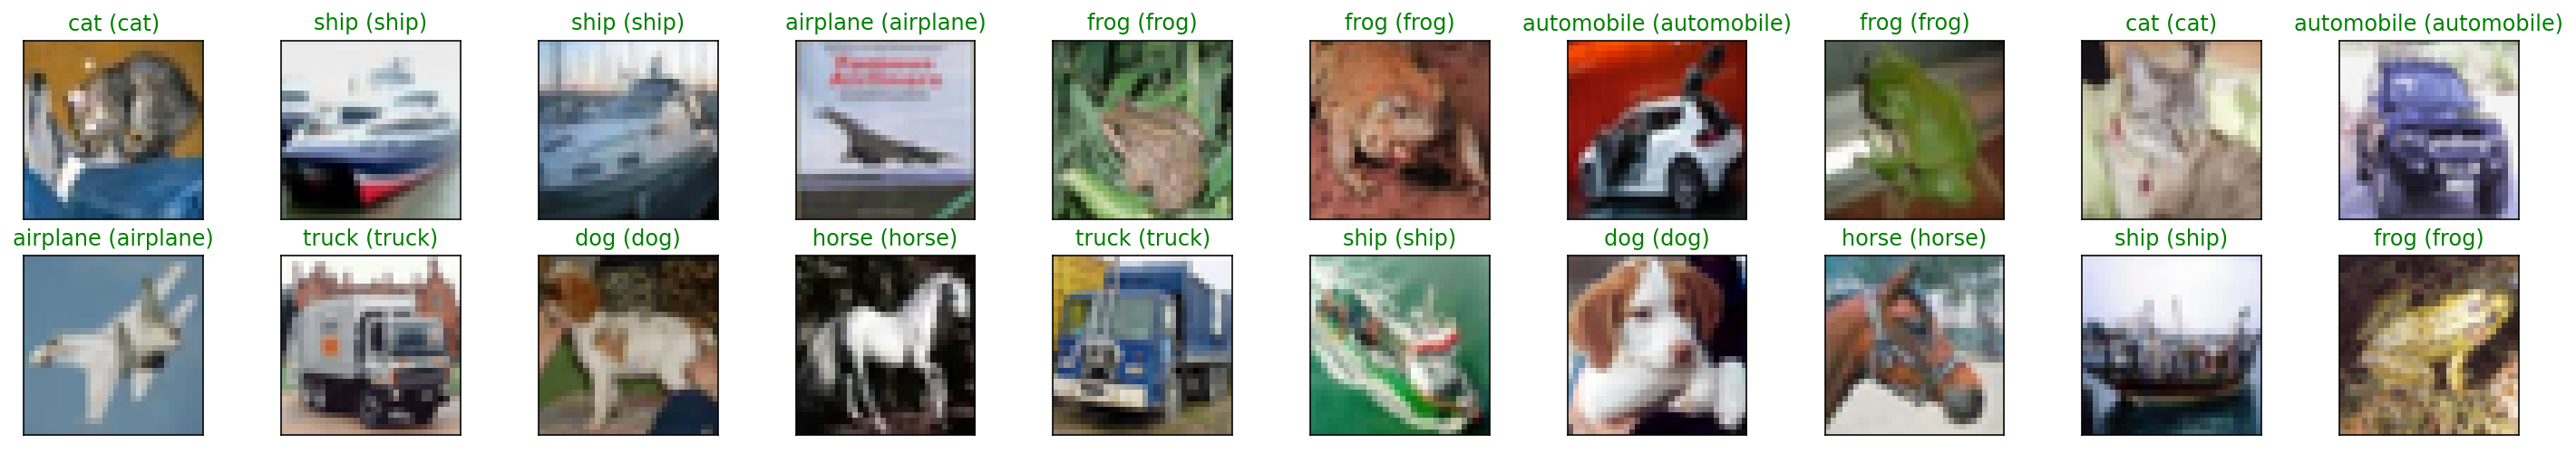

In [45]:
# 先放回cpu
model.to('cpu'); # 不加分号会输出网络结构

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
#if train_on_gpu:
#    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "blue"))

In [47]:
dataiter == dataiter2

False

In [48]:
images == images2

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [40]:
output == output2

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True,